# Байесовские сети. Анализ Титаника.

Суть лабы: строим граф зависимостей, чтобы понять, кто выжил, а кто нет.
Узлы графа — это признаки (пол, класс, порт), а стрелочки показывают, что на что влияет.
Наша цель — посмотреть, как пол, класс и место посадки влияют на шансы спастись.

### Грузим данные и чистим их.

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

file_path = "data/train.csv"
raw_df = pd.read_csv(file_path)

# только признаки, участвующие сети
features = ["Survived", "Sex", "Pclass", "Embarked"]
df = raw_df[features].copy()

# Удаляем записи с пропущенным портом посадки
df.dropna(subset=["Embarked"], inplace=True)

df["Survived"] = df["Survived"].astype(int)
df["Pclass"] = df["Pclass"].astype(int)
df["Sex"] = df["Sex"].astype("category")
df["Embarked"] = df["Embarked"].astype("category")

df.head()

,Survived,Sex,Pclass,Embarked
0,0,male,3,S
1,1,female,1,C
2,1,female,3,S
3,1,female,1,S
4,0,male,3,S


### Как строим граф (наши гипотезы)

Связи между узлами рисуем сами, исходя из логики:

1. Пол влияет на Выживание (Sex -> Survived):
   Потому что "сначала женщины и дети". Женщин спасали охотнее, значит пол важен.

2. Класс влияет на Выживание (Pclass -> Survived):
   Богачи из 1-го класса жили ближе к палубе и шлюпкам, у них было больше шансов.

3. Порт влияет на Класс (Embarked -> Pclass):
   В разных городах садились люди с разным достатком. Где-то больше богатых, где-то бедных мигрантов.

DiGraph with 4 nodes and 3 edges


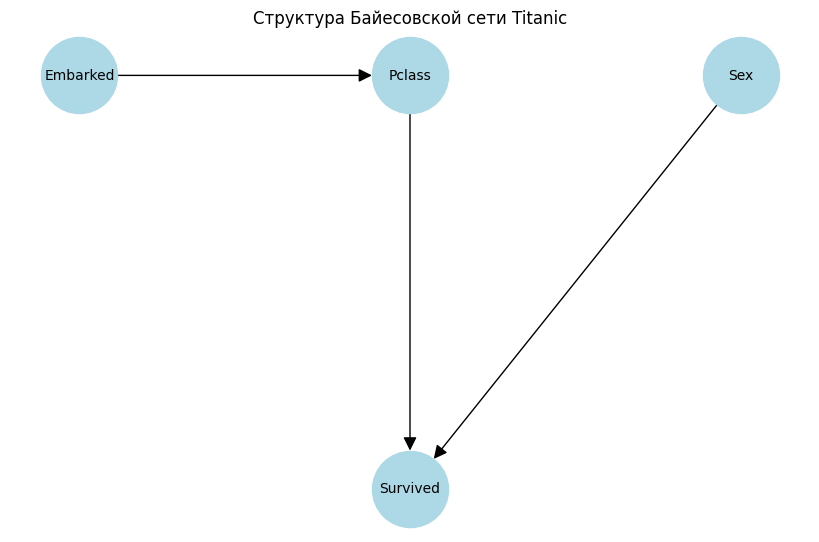

In [5]:
bn = nx.DiGraph()
nodes = ["Embarked", "Pclass", "Sex", "Survived"]
edges = [("Embarked", "Pclass"), ("Pclass", "Survived"), ("Sex", "Survived")]
bn.add_nodes_from(nodes)
bn.add_edges_from(edges)

print(bn)

plt.figure(figsize=(8, 5))
layout = {
    "Embarked": (-1, 1),
    "Pclass": (0, 1),
    "Sex": (1, 1),
    "Survived": (0, 0),
}

nx.draw(
    bn,
    pos=layout,
    with_labels=True,
    node_color="lightblue",
    node_size=3000,
    font_size=10,
    arrowsize=20,
    arrowstyle="-|>",
)
plt.title("Структура Байесовской сети Titanic")
plt.show()

### Считаем вероятности (CPT)

Для каждого узла нужно посчитать таблицу вероятностей.
Если у узла есть родители (например, Выживание зависит от Пола и Класса),
то мы считаем условную вероятность P(Ребенок | Родители).
Просто берем данные и считаем частоты.

In [6]:
print("--- Простые вероятности (без условий) ---")

# Считаем P(Sex)
prob_sex = df["Sex"].value_counts(normalize=True).reset_index()
prob_sex.columns = ["Sex", "probability"]
prob_sex

# Считаем P(Embarked)
prob_embarked = df["Embarked"].value_counts(normalize=True).reset_index()
prob_embarked.columns = ["Embarked", "probability"]
prob_embarked

--- Простые вероятности (без условий) ---


,Embarked,probability
0,S,0.724409
1,C,0.188976
2,Q,0.086614


### Условные вероятности (кто от кого зависит)

In [8]:
# Считаем P(Pclass | Embarked)
parents = ["Embarked"]
child = "Pclass"
group_fields = parents + [child]

# Считаем сколько раз встретилась комбинация
joint_freq = df.groupby(group_fields).size().reset_index(name="joint_count")
# Считаем сколько раз встретились просто Родители
parent_freq = df.groupby(parents).size().reset_index(name="parent_count")

# Делим одно на другое
merged = pd.merge(joint_freq, parent_freq, on=parents)
merged["probability"] = merged["joint_count"] / merged["parent_count"]
cpt_pclass = merged.drop(columns=["joint_count", "parent_count"])

cpt_pclass.sort_values(["Embarked", "Pclass"])

C:\Users\george\AppData\Local\Temp\ipykernel_15928\4005418407.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  joint_freq = df.groupby(group_fields).size().reset_index(name="joint_count")
C:\Users\george\AppData\Local\Temp\ipykernel_15928\4005418407.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  parent_freq = df.groupby(parents).size().reset_index(name="parent_count")


,Embarked,Pclass,probability
0,C,1,0.505952
1,C,2,0.101190
2,C,3,0.392857
3,Q,1,0.025974
4,Q,2,0.038961
5,Q,3,0.935065
6,S,1,0.197205
7,S,2,0.254658
8,S,3,0.548137


### Шансы выжить в зависимости от Пола и Класса (P(Survived | Sex, Pclass)):

In [ ]:
# Считаем P(Survived | Sex, Pclass)
parents = ["Sex", "Pclass"]
child = "Survived"
group_fields = parents + [child]

joint_freq = df.groupby(group_fields).size().reset_index(name="joint_count")
parent_freq = df.groupby(parents).size().reset_index(name="parent_count")

merged = pd.merge(joint_freq, parent_freq, on=parents)
merged["probability"] = merged["joint_count"] / merged["parent_count"]
cpt_survived = merged.drop(columns=["joint_count", "parent_count"])

cpt_survived.sort_values(["Sex", "Pclass", "Survived"])

### Что получилось

Проверим, работает ли наша логика.
Посмотрим вероятности выживания для разных людей.
По идее, женщины из 1-го класса должны выживать чаще всех, а мужчины из 3-го — реже всех.

In [9]:
# Сценарии для проверки
scenarios = [
    ("female", 1, "Женщина, 1 класс"),
    ("female", 3, "Женщина, 3 класс"),
    ("male", 1, "Мужчина, 1 класс"),
    ("male", 3, "Мужчина, 3 класс"),
]

for sex, pclass, desc in scenarios:
    mask = (df["Sex"] == sex) & (df["Pclass"] == pclass)
    prob = df.loc[mask, "Survived"].mean()
    print(f"Шансы выжить ({desc}): {prob:.2%}")

Шансы выжить (Женщина, 1 класс): 96.74%
Шансы выжить (Женщина, 3 класс): 50.00%
Шансы выжить (Мужчина, 1 класс): 36.89%
Шансы выжить (Мужчина, 3 класс): 13.54%


## Короче: гипотезы подтвердились. Пол и Класс реально решают.